In [23]:
import cclib
from ase.thermochemistry import IdealGasThermo
from ase.thermochemistry import HarmonicThermo
from ase.io import read,write
import numpy as np
from numpy import array
import pandas as pd
from scipy.spatial import distance

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

In [24]:
import pickle
import math
import cclib
from ase.io import read
from ase.thermochemistry import IdealGasThermo, HarmonicThermo

P = 101325  # Pressure in Pascal
# T_CVD = [298.15, 973.15, 1023.15, 1123.15, 1223.15, 1323.15]  # Temperature in K
T_CVD = [973.15, 1023.15, 1123.15, 1223.15]  # Temperature in K
ref_files = ['MoCO6', 'MoCO3', 'H2S', 'CO', 'H2']
type = ['nonlinear', 'nonlinear', 'nonlinear', 'linear', 'linear']
sym_num = [24, 1, 1, 1, 2]  # Rotational Symmetry number, Table 10.1, Cramer “Essentials of Computational Chemistry”
# cluster_files = ['25_MoS4H2', '33_Mo2S6H4', '43_Mo3S8H4', '53_Mo4S10H4', '69_Mo5S12', '79_Mo6S14', '89_Mo7S16', '99_Mo8S18',
#                  '109_Mo9S20', '121_Mo10S22']
cluster_files = ['MoS4H2', 'Mo2S6H4', 'Mo3S8H4', 'Mo4S10H4', 'Mo5S12', 'Mo6S14', 'Mo7S16', 'Mo8S18',
                 'Mo9S20']
init = "/home/chesagar/CVD_sagar/reacion_plotting/CVD-manuscript_data/Nucleation/gas-phase/" # change the directory name as per need
fin = ".log"

G_ase_ref = {}
G_ase_cluster = {}
G_ase_cluster_harm = {}
cluster_size = {}
H2S_num_list = {}
count_H2_rem_list = {}

del_G_Ideal = {}
del_G_Harmonic = {}

del_G_Ideal_MoCO3 = {}
del_G_Harmonic_MoCO3 = {}

for j, temp in enumerate(T_CVD):
    G_ase_ref[temp] = {}
    G_ase_cluster[temp] = {}
    G_ase_cluster_harm[temp] = {}
    cluster_size[temp] = {}
    H2S_num_list[temp] = {}
    count_H2_rem_list[temp] = {}
    del_G_Ideal[temp] = {}
    del_G_Harmonic[temp] = {}
    del_G_Ideal_MoCO3[temp] = {}
    del_G_Harmonic_MoCO3[temp] = {}

    for i, ref_file in enumerate(ref_files):
        file_name = init + ref_file + fin
        parser = cclib.io.ccopen(file_name)
        data = parser.parse()
        with open(file_name) as reader:
            for line in reader.read().splitlines():
                if 'SCF Done' in line:
                    last_line = line
                    columns = last_line.split()
        E_au = float(columns[4])
        E_eV = E_au * 27.211324570273
        atoms_list = data.atomnos
        vib_freq = data.vibfreqs
        atoms = read(file_name)
        potE = E_eV
        vibs = vib_freq
        vib_energies = vibs / 8065.54429

        thermo = IdealGasThermo(vib_energies=vib_energies,
                                potentialenergy=potE,
                                atoms=atoms,
                                geometry=str(type[i]),
                                symmetrynumber=sym_num[i],
                                spin=0)

        G_ase_eV = thermo.get_gibbs_energy(temperature=temp, pressure=P)
        G_ase_au = G_ase_eV / 27.211324570273
        G_ase_ref[temp][ref_file] = G_ase_au

    for l, cluster_file in enumerate(cluster_files):
        file_name = init + cluster_file + fin
        parser = cclib.io.ccopen(file_name)
        data = parser.parse()
        atoms_list = data.atomnos
        A = [str(x) for x in atoms_list]
        count_Mo = f'{A.count("42")}'
        count_S = f'{A.count("16")}'
        count_H = f'{A.count("1")}'
        count_C = f'{A.count("6")}'
        Mol_formula = "Mo" + count_Mo + "S" + count_S + "H" + count_H + "C" + count_C + "O" + count_C
        count_H2_rem = (2 * int(count_S) - int(count_H)) / 2
        count_H2_rem_list[temp][cluster_file] = count_H2_rem
        cluster_size[temp][cluster_file] = int(count_Mo)
        H2S_num_list[temp][cluster_file] = int(count_S)

        with open(file_name) as reader:
            for line in reader.read().splitlines():
                if 'SCF Done' in line:
                    last_line = line
                    columns = last_line.split()
        E_au = float(columns[4])
        E_eV = E_au * 27.211324570273
        atoms_list = data.atomnos
        vib_freq = data.vibfreqs
        atoms = read(file_name)
        potE = E_eV
        vibs = vib_freq
        vib_energies = vibs / 8065.54429

        thermo = IdealGasThermo(vib_energies=vib_energies,
                                potentialenergy=potE,
                                atoms=atoms,
                                geometry='nonlinear',
                                symmetrynumber=1,
                                spin=0)

        G_ase_eV = thermo.get_gibbs_energy(temperature=temp, pressure=P)
        G_ase_au = G_ase_eV / 27.211324570273
        G_ase_cluster[temp][cluster_file] = G_ase_au

        thermo_harm = HarmonicThermo(vib_energies, potentialenergy=potE)
        G_ase_harm_eV = thermo_harm.get_helmholtz_energy(temperature=temp, verbose=True)
        G_ase_harm_au = G_ase_harm_eV / 27.211324570273
        G_ase_cluster_harm[temp][cluster_file] = G_ase_harm_au

    for i, cluster_file in enumerate(cluster_files):
        # Considering Mo(CO)6 and H2S as reactants
        del_G_rxn_Ideal = ((G_ase_cluster[temp][cluster_file] + 6 * cluster_size[temp][cluster_file] * G_ase_ref[temp]['CO'] +
                            count_H2_rem_list[temp][cluster_file] * G_ase_ref[temp]['H2']) -
                           (cluster_size[temp][cluster_file] * G_ase_ref[temp]['MoCO6'] +
                            H2S_num_list[temp][cluster_file] * G_ase_ref[temp]['H2S'])) * 627.507
        del_G_Ideal[temp][cluster_file] = del_G_rxn_Ideal
        
        del_G_rxn_harm = ((G_ase_cluster_harm[temp][cluster_file] + 6 * cluster_size[temp][cluster_file] * G_ase_ref[temp]['CO'] +
                           count_H2_rem_list[temp][cluster_file] * G_ase_ref[temp]['H2']) -
                          (cluster_size[temp][cluster_file] * G_ase_ref[temp]['MoCO6'] +
                           H2S_num_list[temp][cluster_file] * G_ase_ref[temp]['H2S'])) * 627.507
        del_G_Harmonic[temp][cluster_file] = del_G_rxn_harm
        
        # Considering Mo(CO)3 and H2S as reactants
        del_G_rxn_Ideal_MoCO3 = ((G_ase_cluster[temp][cluster_file] + 3 * cluster_size[temp][cluster_file] * G_ase_ref[temp]['CO'] +
                            count_H2_rem_list[temp][cluster_file] * G_ase_ref[temp]['H2']) -
                           (cluster_size[temp][cluster_file] * G_ase_ref[temp]['MoCO3'] +
                            H2S_num_list[temp][cluster_file] * G_ase_ref[temp]['H2S'])) * 627.507
        del_G_Ideal_MoCO3[temp][cluster_file] = del_G_rxn_Ideal_MoCO3
        
        del_G_rxn_harm_MoCO3 = ((G_ase_cluster_harm[temp][cluster_file] + 3 * cluster_size[temp][cluster_file] * G_ase_ref[temp]['CO'] +
                           count_H2_rem_list[temp][cluster_file] * G_ase_ref[temp]['H2']) -
                          (cluster_size[temp][cluster_file] * G_ase_ref[temp]['MoCO3'] +
                           H2S_num_list[temp][cluster_file] * G_ase_ref[temp]['H2S'])) * 627.507
        del_G_Harmonic_MoCO3[temp][cluster_file] = del_G_rxn_harm_MoCO3

# Save dictionaries to files
with open('del_G_Ideal.pkl', 'wb') as file:
    pickle.dump(del_G_Ideal, file)
    
with open('del_G_Ideal_MoCO3.pkl', 'wb') as file:
    pickle.dump(del_G_Ideal_MoCO3, file)

with open('del_G_Harmonic.pkl', 'wb') as file:
    pickle.dump(del_G_Harmonic, file)

with open('del_G_Harmonic_MoCO3.pkl', 'wb') as file:
    pickle.dump(del_G_Harmonic_MoCO3, file)

Enthalpy components at T = 973.15 K:
E_pot             -20343.936 eV
E_ZPE                  1.332 eV
Cv_trans (0->T)        0.126 eV
Cv_rot (0->T)          0.126 eV
Cv_vib (0->T)          1.848 eV
(C_v -> C_p)           0.084 eV
-------------------------------
H                 -20340.421 eV

Entropy components at T = 973.15 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0021038 eV/K        2.047 eV
S_rot              0.0012575 eV/K        1.224 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vib              0.0047989 eV/K        4.670 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.001 eV
-------------------------------------------------
S                  0.0081591 eV/K        7.940 eV

Free energy components at T = 973.15 K and P = 101325.0 Pa:
    H     -20340.421 eV
 -T*S         -7.940 eV
-----------------------
    G     -20348.361 eV
Enthalpy components at T = 973.15 K:
E_pot             -11089.402 eV
E_ZPE                  0.67

/home/chesagar/.local/lib/python3.8/site-packages/cclib/parser/utils.py:182: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  r, _ = scipy.spatial.transform.Rotation.align_vectors(b_, a_)


Enthalpy components at T = 973.15 K:
E_pot             -68758.089 eV
E_ZPE                  1.122 eV
Cv_trans (0->T)        0.126 eV
Cv_rot (0->T)          0.126 eV
Cv_vib (0->T)          1.783 eV
(C_v -> C_p)           0.084 eV
-------------------------------
H                 -68754.849 eV

Entropy components at T = 973.15 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0021537 eV/K        2.096 eV
S_rot              0.0015782 eV/K        1.536 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vib              0.0047923 eV/K        4.664 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.001 eV
-------------------------------------------------
S                  0.0085230 eV/K        8.294 eV

Free energy components at T = 973.15 K and P = 101325.0 Pa:
    H     -68754.849 eV
 -T*S         -8.294 eV
-----------------------
    G     -68763.143 eV
Internal energy components at T = 973.15 K:
E_pot             -68758.089 eV
E_ZPE               

Enthalpy components at T = 973.15 K:
E_pot            -186251.475 eV
E_ZPE                  0.975 eV
Cv_trans (0->T)        0.126 eV
Cv_rot (0->T)          0.126 eV
Cv_vib (0->T)          4.390 eV
(C_v -> C_p)           0.084 eV
-------------------------------
H                -186245.775 eV

Entropy components at T = 973.15 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0022978 eV/K        2.236 eV
S_rot              0.0018505 eV/K        1.801 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vib              0.0121498 eV/K       11.824 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.001 eV
-------------------------------------------------
S                  0.0162971 eV/K       15.859 eV

Free energy components at T = 973.15 K and P = 101325.0 Pa:
    H    -186245.775 eV
 -T*S        -15.859 eV
-----------------------
    G    -186261.634 eV
Internal energy components at T = 973.15 K:
E_pot            -186251.475 eV
E_ZPE               

Enthalpy components at T = 1023.15 K:
E_pot             -45214.719 eV
E_ZPE                  0.608 eV
Cv_trans (0->T)        0.132 eV
Cv_rot (0->T)          0.132 eV
Cv_vib (0->T)          0.914 eV
(C_v -> C_p)           0.088 eV
-------------------------------
H                 -45212.844 eV

Entropy components at T = 1023.15 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0020946 eV/K        2.143 eV
S_rot              0.0014473 eV/K        1.481 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vib              0.0021688 eV/K        2.219 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.001 eV
-------------------------------------------------
S                  0.0057096 eV/K        5.842 eV

Free energy components at T = 1023.15 K and P = 101325.0 Pa:
    H     -45212.844 eV
 -T*S         -5.842 eV
-----------------------
    G     -45218.686 eV
Internal energy components at T = 1023.15 K:
E_pot             -45214.719 eV
E_ZPE           

Enthalpy components at T = 1023.15 K:
E_pot            -162739.393 eV
E_ZPE                  0.835 eV
Cv_trans (0->T)        0.132 eV
Cv_rot (0->T)          0.132 eV
Cv_vib (0->T)          3.993 eV
(C_v -> C_p)           0.088 eV
-------------------------------
H                -162734.212 eV

Entropy components at T = 1023.15 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0022899 eV/K        2.343 eV
S_rot              0.0018175 eV/K        1.860 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vib              0.0106940 eV/K       10.942 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.001 eV
-------------------------------------------------
S                  0.0148003 eV/K       15.143 eV

Free energy components at T = 1023.15 K and P = 101325.0 Pa:
    H    -162734.212 eV
 -T*S        -15.143 eV
-----------------------
    G    -162749.355 eV
Internal energy components at T = 1023.15 K:
E_pot            -162739.393 eV
E_ZPE           

Enthalpy components at T = 1123.15 K:
E_pot             -45214.719 eV
E_ZPE                  0.608 eV
Cv_trans (0->T)        0.145 eV
Cv_rot (0->T)          0.145 eV
Cv_vib (0->T)          1.030 eV
(C_v -> C_p)           0.097 eV
-------------------------------
H                 -45212.694 eV

Entropy components at T = 1123.15 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0021147 eV/K        2.375 eV
S_rot              0.0014594 eV/K        1.639 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vib              0.0022769 eV/K        2.557 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.001 eV
-------------------------------------------------
S                  0.0058499 eV/K        6.570 eV

Free energy components at T = 1123.15 K and P = 101325.0 Pa:
    H     -45212.694 eV
 -T*S         -6.570 eV
-----------------------
    G     -45219.264 eV
Internal energy components at T = 1123.15 K:
E_pot             -45214.719 eV
E_ZPE           

Enthalpy components at T = 1123.15 K:
E_pot            -162739.393 eV
E_ZPE                  0.835 eV
Cv_trans (0->T)        0.145 eV
Cv_rot (0->T)          0.145 eV
Cv_vib (0->T)          4.452 eV
(C_v -> C_p)           0.097 eV
-------------------------------
H                -162733.718 eV

Entropy components at T = 1123.15 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0023100 eV/K        2.594 eV
S_rot              0.0018296 eV/K        2.055 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vib              0.0111224 eV/K       12.492 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.001 eV
-------------------------------------------------
S                  0.0152609 eV/K       17.140 eV

Free energy components at T = 1123.15 K and P = 101325.0 Pa:
    H    -162733.718 eV
 -T*S        -17.140 eV
-----------------------
    G    -162750.859 eV
Internal energy components at T = 1123.15 K:
E_pot            -162739.393 eV
E_ZPE           

Enthalpy components at T = 1223.15 K:
E_pot             -45214.719 eV
E_ZPE                  0.608 eV
Cv_trans (0->T)        0.158 eV
Cv_rot (0->T)          0.158 eV
Cv_vib (0->T)          1.147 eV
(C_v -> C_p)           0.105 eV
-------------------------------
H                 -45212.542 eV

Entropy components at T = 1223.15 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0021331 eV/K        2.609 eV
S_rot              0.0014704 eV/K        1.799 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vib              0.0023771 eV/K        2.908 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.001 eV
-------------------------------------------------
S                  0.0059794 eV/K        7.314 eV

Free energy components at T = 1223.15 K and P = 101325.0 Pa:
    H     -45212.542 eV
 -T*S         -7.314 eV
-----------------------
    G     -45219.856 eV
Internal energy components at T = 1223.15 K:
E_pot             -45214.719 eV
E_ZPE           

Enthalpy components at T = 1223.15 K:
E_pot            -162739.393 eV
E_ZPE                  0.835 eV
Cv_trans (0->T)        0.158 eV
Cv_rot (0->T)          0.158 eV
Cv_vib (0->T)          4.913 eV
(C_v -> C_p)           0.105 eV
-------------------------------
H                -162733.224 eV

Entropy components at T = 1223.15 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0023283 eV/K        2.848 eV
S_rot              0.0018406 eV/K        2.251 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vib              0.0115151 eV/K       14.085 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.001 eV
-------------------------------------------------
S                  0.0156829 eV/K       19.183 eV

Free energy components at T = 1223.15 K and P = 101325.0 Pa:
    H    -162733.224 eV
 -T*S        -19.183 eV
-----------------------
    G    -162752.406 eV
Internal energy components at T = 1223.15 K:
E_pot            -162739.393 eV
E_ZPE           

In [25]:
import pickle
import pandas as pd

# Load the data from pickle files
with open('del_G_Ideal.pkl', 'rb') as file:
    del_G_Ideal = pickle.load(file)

with open('del_G_Ideal_MoCO3.pkl', 'rb') as file:
    del_G_Ideal_MoCO3 = pickle.load(file)

with open('del_G_Harmonic.pkl', 'rb') as file:
    del_G_Harmonic = pickle.load(file)
    
with open('del_G_Harmonic_MoCO3.pkl', 'rb') as file:
    del_G_Harmonic_MoCO3 = pickle.load(file)
    
# Convert the dictionaries to DataFrames
df_del_G_Ideal = pd.DataFrame.from_dict(del_G_Ideal)

df_del_G_Ideal_MoCO3 = pd.DataFrame.from_dict(del_G_Ideal_MoCO3)

df_del_G_Harmonic = pd.DataFrame.from_dict(del_G_Harmonic)

df_del_G_Harmonic_MoCO3 = pd.DataFrame.from_dict(del_G_Harmonic_MoCO3)

# Print the DataFrames

print("del_G_Ideal DataFrame:")
print(df_del_G_Ideal)

print("del_G_Ideal_MoCO3 DataFrame:")
print(df_del_G_Ideal_MoCO3)

print("del_G_Harmonic DataFrame:")
print(df_del_G_Harmonic)

print("del_G_Harmonic_MoCO3 DataFrame:")
print(df_del_G_Harmonic_MoCO3)


del_G_Ideal DataFrame:
             973.15      1023.15     1123.15     1223.15
MoS4H2    -39.263047  -46.723339  -61.595266  -76.400707
Mo2S6H4   -68.580744  -82.530325 -110.332263 -138.004579
Mo3S8H4  -125.916359 -146.824893 -188.478800 -229.917111
Mo4S10H4 -166.683507 -194.678016 -250.438475 -305.898054
Mo5S12   -244.063518 -282.244283 -358.284732 -433.901964
Mo6S14   -312.155437 -357.492897 -447.781950 -537.563163
Mo7S16   -374.502451 -426.975965 -531.472391 -635.376407
Mo8S18   -440.747016 -500.252073 -618.746904 -736.564813
Mo9S20   -489.468387 -556.297684 -689.376303 -821.693476
del_G_Ideal_MoCO3 DataFrame:
             973.15      1023.15     1123.15     1223.15
MoS4H2    -38.084567  -40.477323  -45.275494  -50.083480
Mo2S6H4   -66.223785  -70.038293  -77.692718  -85.370125
Mo3S8H4  -122.380920 -128.086845 -139.519483 -150.965430
Mo4S10H4 -161.969590 -169.693952 -185.159386 -200.629145
Mo5S12   -238.171121 -251.014203 -276.685870 -302.315827
Mo6S14   -305.084560 -320.016801 -34

<IPython.core.display.Javascript object>


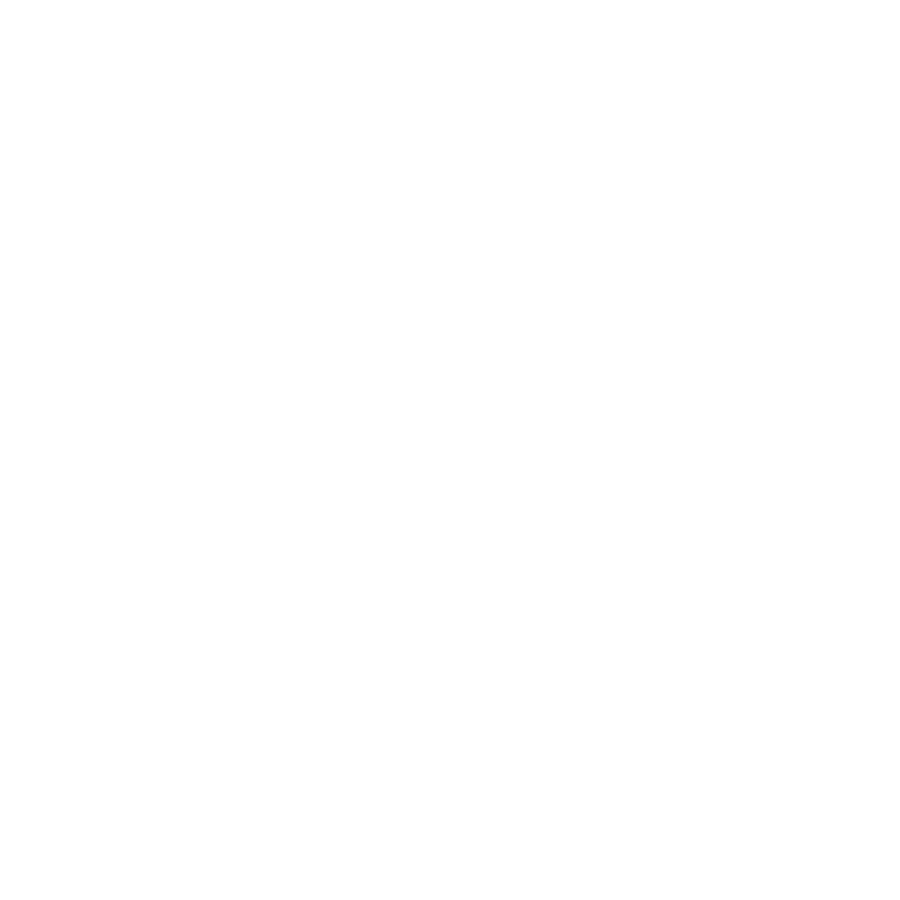

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [32]:
import pickle
import matplotlib.pyplot as plt
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
# Load data from pickle files
with open('del_G_Ideal.pkl', 'rb') as file:
    del_G_Ideal = pickle.load(file)

with open('del_G_Harmonic.pkl', 'rb') as file:
    del_G_Harmonic = pickle.load(file)

# Generate plot for del_G_Ideal
plt.figure(figsize=(6, 6))
#plt.title("ΔG Ideal")
colors = ['red', 'green', 'blue', 'black']
for i, temp in enumerate(T_CVD):
    cluster_files = list(del_G_Ideal[temp].keys())
    x_values = [cluster_size[temp][cluster_file] for cluster_file in cluster_files]
    y_values = [del_G_Ideal[temp][cluster_file] for cluster_file in cluster_files]
    plt.plot(x_values, y_values, 'o', color=colors[i], linestyle='dashed', label=f"T = {temp} K")
plt.ylabel(r'$\Delta$G$^0$ (kcal/mol)',fontsize=12,fontweight='bold')
plt.xlabel("Cluster Size",fontsize=12,fontweight='bold')
x_ticks = range(1, len(cluster_files) + 1)
x_labels = [f"Mo{str(x).translate(SUB)}" for x in x_ticks]
plt.xticks(x_ticks, x_labels)
plt.legend()

#fig.tight_layout(pad=3.0)

plt.savefig("/home/chesagar/CVD_sagar/reacion_plotting/CVD-manuscript_data/Fig/Nucleation_Ideal_final.jpg", dpi=500) # change the directory name as per need
plt.show()

# Generate plot for del_G_Harmonic
# plt.figure(figsize=(6, 5))
# plt.title("ΔG Harmonic")
# for i, temp in enumerate(T_CVD):
#     cluster_files = list(del_G_Harmonic[temp].keys())
#     x_values = [cluster_size[temp][cluster_file] for cluster_file in cluster_files]
#     y_values = [del_G_Harmonic[temp][cluster_file] for cluster_file in cluster_files]
#     plt.plot(x_values, y_values, 'o', color=colors[i], linestyle='dashed', label=f"T = {temp} K")
# plt.ylabel(r'$\Delta$G$^0$ (kcal/mol)',fontsize=12,fontweight='bold')
# plt.xlabel("Cluster Size",fontsize=12,fontweight='bold')
# plt.xticks(x_ticks, x_labels)
# plt.legend()
# #plt.savefig("del_G_Harmonic_plot.png")
# plt.show()


# Nucleation_On-SiO2

In [27]:
import os
import warnings 
import pickle
import numpy as np
from ase.thermochemistry import HarmonicThermo

root_dir = '/home/chesagar/CVD_sagar/reacion_plotting/CVD-manuscript_data/Nucleation/solid/' # change the directory name as per need
subdir1_name = "opt"
tot_F_dict = {}

for directory in os.listdir(root_dir):
    full_dir_path = os.path.join(root_dir, directory)
    if os.path.isdir(full_dir_path):
        os.chdir(full_dir_path)
        if subdir1_name in os.listdir(full_dir_path) and os.path.isdir(os.path.join(full_dir_path, subdir1_name)):
            os.chdir(os.path.join(full_dir_path, subdir1_name))
            file = open('OSZICAR', 'r')
            lines = file.readlines()
            last_line = lines[-1]
            potE = last_line.split()[4]

            print(float(potE))
            os.chdir('../')
            subdir2_name = "normal_mode"
            current_dir = os.getcwd()
            print(current_dir)
            os.chdir(os.path.join(current_dir, subdir2_name))

            os.system("~/softwares/vtstscripts-981/dymmatrix.pl DISPLACECAR OUTCAR")
            os.system("grep '... 0' freq.dat | awk '{print $1}'>Freq.txt; grep '... 1' freq.dat | awk '{print $1}'>imF1")

            y = np.loadtxt("Freq.txt", dtype=float)

            text_file = open("Freq.txt", "r")
            lines = text_file.readlines()
            text_file.close()

            rep = []
            for x in lines:
                rep.append(x.replace("\n", ""))

            vibs = np.array(rep)
            vibs = vibs.astype('float64')

            vib_energies = vibs / 8065.54429

            T = np.array([298.15, 973.15, 1023.15, 1123.15, 1223.15, 1323.15])

            thermo = HarmonicThermo(vib_energies=vib_energies, potentialenergy=float(potE))

            free_energy_dict = {}
            for i in T:
                free_energy_dict[i] = []
            for j in T:
                F = thermo.get_helmholtz_energy(temperature=int(j), verbose=True)
                free_energy_dict[j].append(F)
            tot_F_dict[directory] = free_energy_dict

os.chdir(root_dir)

with open('tot_F_dict.pkl', 'wb') as file:
    print(tot_F_dict)
    pickle.dump(tot_F_dict, file)
print("tot_F_dict dictionary saved successfully.")

-3124.3188
/home/chesagar/CVD_sagar/reacion_plotting/CVD-manuscript_data/Nucleation/solid/SiO2-Mo10


<ipython-input-27-a3f5c6cc8cfa>:32: UserWarning: loadtxt: Empty input file: "Freq.txt"
  y = np.loadtxt("Freq.txt", dtype=float)


Internal energy components at T = 298.00 K:
E_pot              -3124.319 eV
E_ZPE                  0.000 eV
Cv_harm (0->T)         0.000 eV
-------------------------------
U                  -3124.319 eV

Entropy components at T = 298.00 K:
                           S               T*S
S_harm             0.0000000 eV/K        0.000 eV
-------------------------------------------------
S                  0.0000000 eV/K        0.000 eV

Free energy components at T = 298.00 K:
    U      -3124.319 eV
 -T*S         -0.000 eV
-----------------------
    F      -3124.319 eV
Internal energy components at T = 973.00 K:
E_pot              -3124.319 eV
E_ZPE                  0.000 eV
Cv_harm (0->T)         0.000 eV
-------------------------------
U                  -3124.319 eV

Entropy components at T = 973.00 K:
                           S               T*S
S_harm             0.0000000 eV/K        0.000 eV
-------------------------------------------------
S                  0.0000000 eV/K    

Internal energy components at T = 298.00 K:
E_pot              -2988.568 eV
E_ZPE                  0.000 eV
Cv_harm (0->T)         0.000 eV
-------------------------------
U                  -2988.568 eV

Entropy components at T = 298.00 K:
                           S               T*S
S_harm             0.0000000 eV/K        0.000 eV
-------------------------------------------------
S                  0.0000000 eV/K        0.000 eV

Free energy components at T = 298.00 K:
    U      -2988.568 eV
 -T*S         -0.000 eV
-----------------------
    F      -2988.568 eV
Internal energy components at T = 973.00 K:
E_pot              -2988.568 eV
E_ZPE                  0.000 eV
Cv_harm (0->T)         0.000 eV
-------------------------------
U                  -2988.568 eV

Entropy components at T = 973.00 K:
                           S               T*S
S_harm             0.0000000 eV/K        0.000 eV
-------------------------------------------------
S                  0.0000000 eV/K    

Internal energy components at T = 298.00 K:
E_pot              -3013.946 eV
E_ZPE                  0.758 eV
Cv_harm (0->T)         0.658 eV
-------------------------------
U                  -3012.531 eV

Entropy components at T = 298.00 K:
                           S               T*S
S_harm             0.0047419 eV/K        1.413 eV
-------------------------------------------------
S                  0.0047419 eV/K        1.413 eV

Free energy components at T = 298.00 K:
    U      -3012.531 eV
 -T*S         -1.413 eV
-----------------------
    F      -3013.944 eV
Internal energy components at T = 973.00 K:
E_pot              -3013.946 eV
E_ZPE                  0.758 eV
Cv_harm (0->T)         3.251 eV
-------------------------------
U                  -3009.937 eV

Entropy components at T = 973.00 K:
                           S               T*S
S_harm             0.0092316 eV/K        8.982 eV
-------------------------------------------------
S                  0.0092316 eV/K    

Internal energy components at T = 298.00 K:
E_pot              -3058.007 eV
E_ZPE                  1.009 eV
Cv_harm (0->T)         0.928 eV
-------------------------------
U                  -3056.070 eV

Entropy components at T = 298.00 K:
                           S               T*S
S_harm             0.0065381 eV/K        1.948 eV
-------------------------------------------------
S                  0.0065381 eV/K        1.948 eV

Free energy components at T = 298.00 K:
    U      -3056.070 eV
 -T*S         -1.948 eV
-----------------------
    F      -3058.018 eV
Internal energy components at T = 973.00 K:
E_pot              -3058.007 eV
E_ZPE                  1.009 eV
Cv_harm (0->T)         4.528 eV
-------------------------------
U                  -3052.470 eV

Entropy components at T = 973.00 K:
                           S               T*S
S_harm             0.0127762 eV/K       12.431 eV
-------------------------------------------------
S                  0.0127762 eV/K    

Internal energy components at T = 298.00 K:
E_pot              -3102.301 eV
E_ZPE                  1.324 eV
Cv_harm (0->T)         1.153 eV
-------------------------------
U                  -3099.824 eV

Entropy components at T = 298.00 K:
                           S               T*S
S_harm             0.0079704 eV/K        2.375 eV
-------------------------------------------------
S                  0.0079704 eV/K        2.375 eV

Free energy components at T = 298.00 K:
    U      -3099.824 eV
 -T*S         -2.375 eV
-----------------------
    F      -3102.199 eV
Internal energy components at T = 973.00 K:
E_pot              -3102.301 eV
E_ZPE                  1.324 eV
Cv_harm (0->T)         5.747 eV
-------------------------------
U                  -3095.229 eV

Entropy components at T = 973.00 K:
                           S               T*S
S_harm             0.0159289 eV/K       15.499 eV
-------------------------------------------------
S                  0.0159289 eV/K    

Internal energy components at T = 298.00 K:
E_pot              -2944.363 eV
E_ZPE                  0.981 eV
Cv_harm (0->T)         0.172 eV
-------------------------------
U                  -2943.210 eV

Entropy components at T = 298.00 K:
                           S               T*S
S_harm             0.0011444 eV/K        0.341 eV
-------------------------------------------------
S                  0.0011444 eV/K        0.341 eV

Free energy components at T = 298.00 K:
    U      -2943.210 eV
 -T*S         -0.341 eV
-----------------------
    F      -2943.551 eV
Internal energy components at T = 973.00 K:
E_pot              -2944.363 eV
E_ZPE                  0.981 eV
Cv_harm (0->T)         1.046 eV
-------------------------------
U                  -2942.336 eV

Entropy components at T = 973.00 K:
                           S               T*S
S_harm             0.0026286 eV/K        2.558 eV
-------------------------------------------------
S                  0.0026286 eV/K    

Internal energy components at T = 298.00 K:
E_pot              -2940.865 eV
E_ZPE                  0.481 eV
Cv_harm (0->T)         0.139 eV
-------------------------------
U                  -2940.245 eV

Entropy components at T = 298.00 K:
                           S               T*S
S_harm             0.0009122 eV/K        0.272 eV
-------------------------------------------------
S                  0.0009122 eV/K        0.272 eV

Free energy components at T = 298.00 K:
    U      -2940.245 eV
 -T*S         -0.272 eV
-----------------------
    F      -2940.517 eV
Internal energy components at T = 973.00 K:
E_pot              -2940.865 eV
E_ZPE                  0.481 eV
Cv_harm (0->T)         0.814 eV
-------------------------------
U                  -2939.571 eV

Entropy components at T = 973.00 K:
                           S               T*S
S_harm             0.0020617 eV/K        2.006 eV
-------------------------------------------------
S                  0.0020617 eV/K    

Internal energy components at T = 298.00 K:
E_pot              -3006.955 eV
E_ZPE                  1.381 eV
Cv_harm (0->T)         0.293 eV
-------------------------------
U                  -3005.281 eV

Entropy components at T = 298.00 K:
                           S               T*S
S_harm             0.0017645 eV/K        0.526 eV
-------------------------------------------------
S                  0.0017645 eV/K        0.526 eV

Free energy components at T = 298.00 K:
    U      -3005.281 eV
 -T*S         -0.526 eV
-----------------------
    F      -3005.807 eV
Internal energy components at T = 973.00 K:
E_pot              -3006.955 eV
E_ZPE                  1.381 eV
Cv_harm (0->T)         1.866 eV
-------------------------------
U                  -3003.709 eV

Entropy components at T = 973.00 K:
                           S               T*S
S_harm             0.0044367 eV/K        4.317 eV
-------------------------------------------------
S                  0.0044367 eV/K    

In [28]:
with open('tot_F_dict.pkl', 'rb') as file:
    tot_F_dict = pickle.load(file)
    
# Convert the dictionaries to DataFrames
df_tot_F_dict = pd.DataFrame.from_dict(tot_F_dict)

print("tot_F_dict DataFrame:")
print(df_tot_F_dict)

tot_F_dict DataFrame:
            SiO2-Mo10      SiO2-Mo2      SiO2-Mo3               SiO2-Mo4  \
298.15   [-3124.3188]  [-2966.3802]  [-2988.5683]  [-3007.5937656393653]   
973.15   [-3124.3188]  [-2966.3802]  [-2988.5683]  [-3011.9576983083825]   
1023.15  [-3124.3188]  [-2966.3802]  [-2988.5683]   [-3012.377342373849]   
1123.15  [-3124.3188]  [-2966.3802]  [-2988.5683]   [-3013.245643534168]   
1223.15  [-3124.3188]  [-2966.3802]  [-2988.5683]   [-3014.150026759388]   
1323.15  [-3124.3188]  [-2966.3802]  [-2988.5683]  [-3015.0877794902567]   

                      SiO2-Mo5               SiO2-Mo6               SiO2-Mo7  \
298.15   [-3013.9438225818285]   [-3036.749973430797]   [-3058.018210619586]   
973.15    [-3018.919773275078]   [-3042.675604976741]   [-3064.900870261858]   
1023.15  [-3019.3863854274705]  [-3043.2315870429934]  [-3065.5466461145024]   
1123.15   [-3020.348413163041]   [-3044.377901446434]   [-3066.878079412903]   
1223.15   [-3021.346086326783]  [-3045.566720

In [29]:
from ase.thermochemistry import IdealGasThermo
from ase.io import *
import numpy as np
from numpy import array
from ase.build import molecule

import os
import warnings 
root_dir='/home/chesagar/CVD_sagar/reacion_plotting/CVD-manuscript_data/Nucleation/gas_periodic/' # change the directory name as per need
tot_G_dict_mol = {}
symm_num =[1,1,1,1,2] 
geometry_vals =[ 'nonlinear', 'nonlinear', 'nonlinear', 'linear', 'linear']

relevant_files = ['MoCO6', 'MoCO3', 'H2S', 'CO', 'H2']

for e,file_name in enumerate(relevant_files):
    print(file_name)
    os.chdir(os.path.join(root_dir, file_name))
    subdir1_name = "opt"
    current_dir = os.getcwd()
    os.chdir(os.path.join(current_dir, subdir1_name))

    file = open('OSZICAR', 'r')
    lines = file.readlines()
    last_line = lines[-1]
    potE = last_line.split()[4]

    print(float(potE))
    os.chdir('../')
    subdir2_name = "normal_mode_IBRION"
    current_dir = os.getcwd()
    os.chdir(os.path.join(current_dir, subdir2_name))
    file = "OUTCAR"
    freq = []
    freq_img = []
    with open(file) as reader:
        for line in reader.read().splitlines():
            if '2PiTHz' in line:
                freq_line = line.split()
                if freq_line[1]=="f":
                    freq.append(freq_line[7])
                if freq_line[1]=="f/i=":
                    freq_img.append(freq_line[6])
    print(freq)
    print(freq_img)
    atoms=read(file_name+'.xyz')
    print(atoms)
    if geometry_vals[e] == 'nonlinear':
        num_freq_mode = 3*len(atoms)-6
    else: 
        num_freq_mode = 3*len(atoms)-5
    truncated_freq = freq[:num_freq_mode]
    print(truncated_freq)
    vibs = np.array(truncated_freq,dtype=float)
    vib_energies = vibs / 8065.54429

    T = [298.15, 973.15, 1023.15, 1123.15, 1223.15, 1323.15]
    
    thermo = IdealGasThermo(vib_energies=vib_energies,
                                    potentialenergy=float(potE),
                                    atoms=atoms,
                                    geometry=geometry_vals[e],
                                    symmetrynumber=symm_num[e], spin=0)

    free_energy_dict = {}
    for i in T:
        free_energy_dict[i] = []
    free_energy = []    
    for j in range(len(T)):
        G = thermo.get_gibbs_energy(temperature=int(T[j]), pressure=101325)
        free_energy_dict[T[j]].append(G)
        free_energy.append(G)
        
    tot_G_dict_mol[file_name] = free_energy_dict

os.chdir('/home/chesagar/CVD_sagar/reacion_plotting/CVD-manuscript_data/Nucleation/solid') # change the directory name as per need

with open('tot_G_dict_mol.pkl', 'wb') as file:
    print(tot_G_dict_mol)
    pickle.dump(tot_G_dict_mol, file)
print("tot_G_dict_mol dictionary saved successfully.")

MoCO6
-105.60306
['2110.883628', '2019.636415', '2018.502614', '1995.257251', '1994.616531', '1993.964792', '598.701776', '597.997071', '596.677922', '507.662239', '507.580626', '507.498036', '468.848518', '468.691712', '468.474921', '422.691813', '408.328755', '405.897295', '398.141528', '394.717019', '394.175946', '338.002610', '336.586192', '336.504941', '82.727513', '80.288801', '78.774766', '78.065443', '75.464988', '72.844075', '57.855433', '56.053747', '50.520746', '34.575369', '5.999867']
['3.079820', '4.660164', '8.529856', '17.683958']
Atoms(symbols='MoC6O6', pbc=False)
['2110.883628', '2019.636415', '2018.502614', '1995.257251', '1994.616531', '1993.964792', '598.701776', '597.997071', '596.677922', '507.662239', '507.580626', '507.498036', '468.848518', '468.691712', '468.474921', '422.691813', '408.328755', '405.897295', '398.141528', '394.717019', '394.175946', '338.002610', '336.586192', '336.504941', '82.727513', '80.288801', '78.774766', '78.065443', '75.464988', '72.8

    G        -13.714 eV
Enthalpy components at T = 1323.00 K:
E_pot                -11.224 eV
E_ZPE                  0.402 eV
Cv_trans (0->T)        0.171 eV
Cv_rot (0->T)          0.171 eV
Cv_vib (0->T)          0.095 eV
(C_v -> C_p)           0.114 eV
-------------------------------
H                    -10.270 eV

Entropy components at T = 1323.00 K and P = 101325.0 Pa:
                           S               T*S
S_trans (1 bar)    0.0019053 eV/K        2.521 eV
S_rot              0.0007998 eV/K        1.058 eV
S_elec             0.0000000 eV/K        0.000 eV
S_vib              0.0001098 eV/K        0.145 eV
S (1 bar -> P)    -0.0000011 eV/K       -0.002 eV
-------------------------------------------------
S                  0.0028138 eV/K        3.723 eV

Free energy components at T = 1323.00 K and P = 101325.0 Pa:
    H        -10.270 eV
 -T*S         -3.723 eV
-----------------------
    G        -13.993 eV
CO
-14.786106
['2127.939661', '9.388466', '5.371460']
['1.310471', '9

In [30]:
cluster_size = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
H2S_Num = np.array([4, 6, 8, 10, 12, 14, 16, 18, 20])
E_SiO2 = -2901.3046 # in eV

nucl_G_Harmonic = {}
T = np.array([298.15, 973.15, 1023.15, 1123.15, 1223.15, 1323.15])
for i in T:
    nucl_G_Harmonic[i] = []  

for j in T:
    for i in cluster_size:
        if i == 1:
            del_G_rxn_harm_f = ((tot_F_dict['SiO2-Mo'+str(i)][j][0] + 6*i*tot_G_dict_mol['CO'][j][0] + 
                                 (H2S_Num[i-1]-1)*tot_G_dict_mol['H2'][j][0]) - 
                                ((i*tot_G_dict_mol['MoCO6'][j][0] + H2S_Num[i-1]*tot_G_dict_mol['H2S'][j][0]) + E_SiO2))*23.0609
            #print('SiO2-Mo'+str(i)+' at '+ str(j)+"K =",del_G_rxn_harm_f)
            nucl_G_Harmonic[j].append(del_G_rxn_harm_f)
        elif i < 5:
            del_G_rxn_harm_f = ((tot_F_dict['SiO2-Mo'+str(i)][j][0] + 6*i*tot_G_dict_mol['CO'][j][0] + 
                                 (H2S_Num[i-1]-2)*tot_G_dict_mol['H2'][j][0]) - 
                                ((i*tot_G_dict_mol['MoCO6'][j][0] + H2S_Num[i-1]*tot_G_dict_mol['H2S'][j][0]) + E_SiO2))*23.0609
            #print('SiO2-Mo'+str(i)+' at '+ str(j)+"K =",del_G_rxn_harm_f)
            nucl_G_Harmonic[j].append(del_G_rxn_harm_f)
        else:
            del_G_rxn_harm_f = ((tot_F_dict['SiO2-Mo'+str(i)][j][0] + 6*i*tot_G_dict_mol['CO'][j][0] + 
                                 (H2S_Num[i-1])*tot_G_dict_mol['H2'][j][0]) - 
                                ((i*tot_G_dict_mol['MoCO6'][j][0] + H2S_Num[i-1]*tot_G_dict_mol['H2S'][j][0]) + E_SiO2))*23.0609
            #print('SiO2-Mo'+str(i)+' at '+ str(j)+"K =",del_G_rxn_harm_f)
            nucl_G_Harmonic[j].append(del_G_rxn_harm_f)

<IPython.core.display.Javascript object>


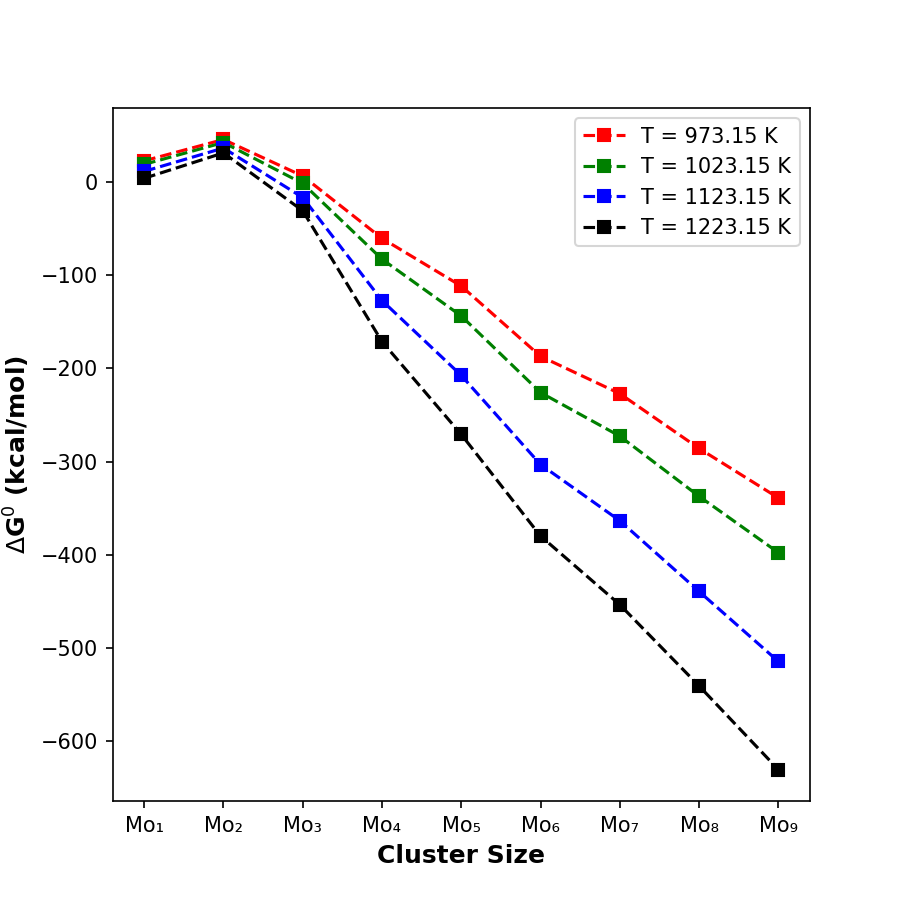

In [31]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

plt.plot(cluster_size, nucl_G_Harmonic[973.15], "s", color="red", linestyle='dashed')
plt.plot(cluster_size, nucl_G_Harmonic[1023.15], "s", color="green", linestyle='dashed')
plt.plot(cluster_size, nucl_G_Harmonic[1123.15], "s", color="blue", linestyle='dashed')
plt.plot(cluster_size, nucl_G_Harmonic[1223.15], "s", color="black", linestyle='dashed')

plt.legend( [u"T = 973.15 K", u"T = 1023.15 K",  u"T = 1123.15 K", u"T = 1223.15 K"])


plt.ylabel(r'$\Delta$G$^0$ (kcal/mol)',fontsize=12,fontweight='bold')
plt.xlabel("Cluster Size",fontsize=12,fontweight='bold')
x_ticks = range(1, len(cluster_size) + 1)
x_labels = [f"Mo{str(x).translate(SUB)}" for x in x_ticks]
plt.xticks(x_ticks, x_labels)

#plt.title('Mo(CO)$_3$ (s) + (x-1) Mo(CO)$_3$ (g) + y H$_2$S (g) \u2192 Mo$_x$S$_y$H$_4$ (s) + 3x CO (g) + (y-2) H$_2$ (g)', fontsize=9)
#plt.text(4, max(del_G_Ideal[0])-20, "P = "+ "{:.1e}".format((P)) + " Pa", fontsize=11,  color='red')

plt.show()

plt.savefig("/home/chesagar/CVD_sagar/reacion_plotting/CVD-manuscript_data/Fig/Nucleation_Mo_Mo9_on-SiO2.jpg", dpi=500) # change the directory name as per need
